# Fantasy Premier League Player Goal Analysis

### Created by PouncingZebra 

## Hypothesis
Picking a fantasy football team requires extensive knowledge of the league's players.  I believe that by looking at statistics from prior matches and the known information about future matches, players can be ranked on how well they can be expected to play.
My project looks at a focused area within the Premier League, how many goals a player scores.  I wanted to predict how many goals a player can be expected to score.  This information will allow for the creation of the best roster based on goals scored to pick for fantasy football.

## Dataset
The data was extracted from : Fantrax, a Premier League statistics website that keeps track of weekly scores on an immediate basis. Numerous sporting statistics are recorded during each match to see how good players and teams are and to be able to compare one person/team to another.
The data we haven taken includes the player, their team, position, ranking, and the number of games played this year.  As well, the data has various features on the statistics from the games played.

In [1]:
import numpy as np # imports a fast numerical programming library
import scipy as sp # imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm # allows us easy access to colormaps
import matplotlib.pyplot as plt # sets up plotting under plt
import pandas as pd # lets us handle data as dataframes
import seaborn as sns
import re
import random
import requests

%matplotlib inline

#BPL = British Premier League

BPLplayerStats1_url = "https://www.fantrax.com/newui/EPL/statsPlayers.go?isSubmit=y&sId=&sortOrder=SCORING_CATEGORY&sortScId=6340&prevPageNumber=1&pageNumber=&season=918&maxResultsPerPage=100&scKind=NON_GOALIE_STANDARD&position=-2"
BPLplayerStats2_url = "https://www.fantrax.com/newui/EPL/statsPlayers.go?isSubmit=y&sId=&sortOrder=SCORING_CATEGORY&sortScId=6340&prevPageNumber=1&pageNumber=2&season=918&maxResultsPerPage=100&scKind=NON_GOALIE_STANDARD&position=-2"
BPLplayerStats3_url = "https://www.fantrax.com/newui/EPL/statsPlayers.go?isSubmit=y&sId=&sortOrder=SCORING_CATEGORY&sortScId=6340&prevPageNumber=2&pageNumber=3&season=918&maxResultsPerPage=100&scKind=NON_GOALIE_STANDARD&position=-2"
BPLplayerStats4_url = "https://www.fantrax.com/newui/EPL/statsPlayers.go?isSubmit=y&sId=&sortOrder=SCORING_CATEGORY&sortScId=6340&prevPageNumber=3&pageNumber=4&season=918&maxResultsPerPage=100&scKind=NON_GOALIE_STANDARD&position=-2"

BPLplayerStats1_table = pd.read_html(BPLplayerStats1_url, encoding='utf-8')
BPLplayerStats2_table = pd.read_html(BPLplayerStats2_url, encoding='utf-8')
BPLplayerStats3_table = pd.read_html(BPLplayerStats3_url, encoding='utf-8')
BPLplayerStats4_table = pd.read_html(BPLplayerStats4_url, encoding='utf-8')

#Player Stats Page 1
playerStats1 = BPLplayerStats1_table[1]
playerStats1_header = playerStats1.iloc[0] 
playerStats1 = playerStats1[1:]
playerStats1.columns = playerStats1_header

#Player Stats Page 2
playerStats2 = BPLplayerStats2_table[1]
playerStats2_header = playerStats2.iloc[0] 
playerStats2 = playerStats2[1:]
playerStats2.columns = playerStats2_header 

#Player Stats Page 3
playerStats3 = BPLplayerStats3_table[1]
playerStats3_header = playerStats3.iloc[0] 
playerStats3 = playerStats3[1:]
playerStats3.columns = playerStats3_header 

#Player Stats Page 4
playerStats4 = BPLplayerStats4_table[1]
playerStats4_header = playerStats4.iloc[0]
playerStats4 = playerStats4[1:] 
playerStats4.columns = playerStats4_header

playerStatsFrames = [playerStats1, playerStats2, playerStats3, playerStats4]
playerStats = pd.concat(playerStatsFrames)
playerStats = playerStats.reset_index(drop=True)

#Splitting players from team
playerTeams = pd.DataFrame(playerStats.Player.str.split(' - ',1).tolist(),
                                   columns = ['Player','Team'])


del playerStats['Player']
stats = pd.merge(playerTeams, playerStats, left_on=playerStats.index, 
                 right_on=playerStats.index, left_index=True, right_index=True)

stats.head()

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,S,Min/G,FC,FS,YC,RC,DPt
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,30,85.5,16,21,1,0,19
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,36,88.1,24,19,3,0,33
2,"Hazard, Eden",CHE,T2,F,14,11,7,6,13,17,41,75.2,4,43,2,0,10
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,33,75.1,4,13,0,0,4
4,"Agüero, Sergio",MCI,T4,F,13,13,8,4,12,19,55,74.2,8,8,2,0,14


In [2]:
stats.describe()

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,S,Min/G,FC,FS,YC,RC,DPt
count,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400
unique,400,20,14,3,15,16,11,8,14,23,43,264,30,33,7,3,43
top,"Alderweireld, Toby",MUN,T239,M,15,15,0,0,0,0,0,90.0,1,1,0,0,0
freq,1,23,162,155,59,40,228,239,162,123,48,43,32,42,143,378,26


## Data Preprocessing
Since this information is very sought after, the recorded data is accurate and does not have missing values that need to be dealt with.  However, I did need to change the datatypes and calculate a few extra features for our model.  Two features that I found were necessary were shot percentage and total minutes played.

In [3]:
stats['GP'] = stats['GP'].astype('int')
stats['G'] = stats['G'].astype('int')
stats['A'] = stats['A'].astype('int')
stats['SOT'] = stats['SOT'].astype('int')
stats['S'] = stats['S'].astype('int')
stats['FC'] = stats['FC'].astype('int')
stats['FS'] = stats['FS'].astype('int')
stats['Min/G'] = stats['Min/G'].astype('double')
stats['GP'] = stats['GP'].astype('int')

In [4]:
#Calculating percentage of shots on target
#SP = Shot Percentage
stats['SP'] = stats['SOT']/stats['S']
# MP = Minutes Played
stats['MP'] = stats['Min/G']*stats['GP']
stats.head(10)

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,S,Min/G,FC,FS,YC,RC,DPt,SP,MP
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,30,85.5,16,21,1,0,19,0.533333,1026.0
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,36,88.1,24,19,3,0,33,0.444444,1321.5
2,"Hazard, Eden",CHE,T2,F,14,11,7,6,13,17,41,75.2,4,43,2,0,10,0.414634,1052.8
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,33,75.1,4,13,0,0,4,0.454545,1126.5
4,"Agüero, Sergio",MCI,T4,F,13,13,8,4,12,19,55,74.2,8,8,2,0,14,0.345455,964.6
5,"Kane, Harry",TOT,T6,F,15,15,9,2,11,27,51,89.6,18,34,3,0,27,0.529412,1344.0
6,"Fraser, Ryan",BOUR,T6,M,15,15,4,7,11,10,21,85.0,0,26,1,0,3,0.476190,1275.0
7,Mohamed Salah,LIV,T6,F,15,14,7,4,11,24,53,81.3,12,14,0,0,12,0.452830,1219.5
8,"Sané, Leroy",MCI,T6,F,13,8,6,5,11,12,25,59.5,3,6,1,0,6,0.480000,773.5
9,"Mitrovic, Aleksandar",FUL,T10,F,15,15,7,2,9,19,53,89.7,21,24,4,0,33,0.358491,1345.5


## Data Analysis and Visualization

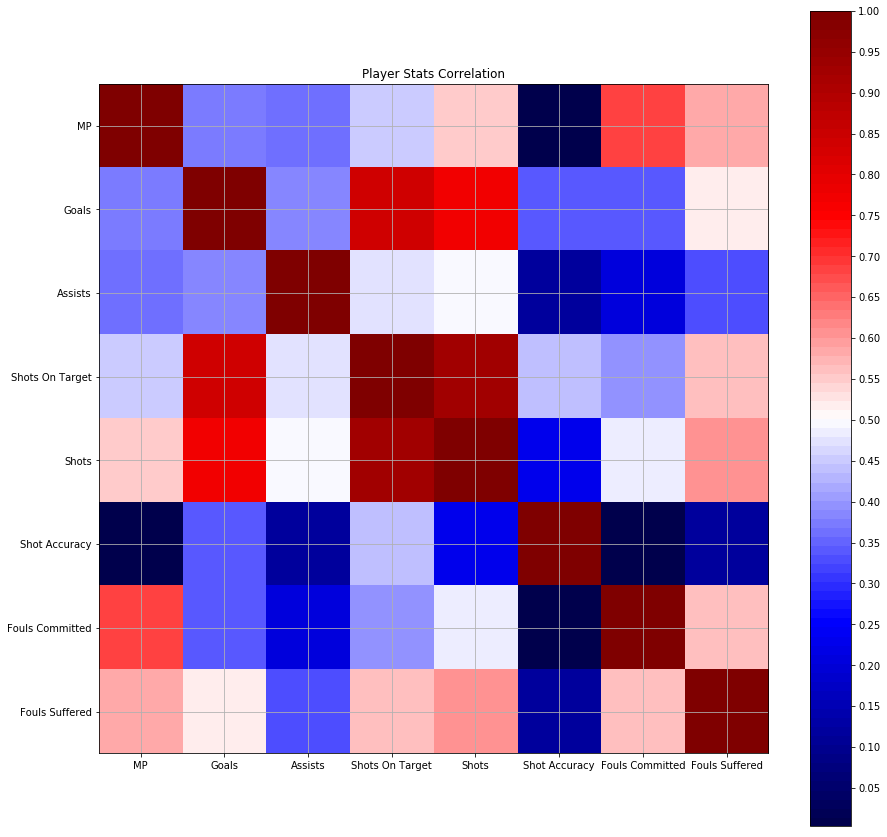

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
cmap = cm.get_cmap('seismic', 90)
cax = ax1.imshow(stats[['MP', 'G', 'A', 'SOT', 'S', 'SP', 'FC', 'FS']].corr(), interpolation="nearest", cmap=cmap)
ax1.grid(True)
plt.title('Player Stats Correlation')
labels=['MP', 'Goals', 'Assists', 'Shots On Target', 'Shots', 'Shot Accuracy','Fouls Committed', 'Fouls Suffered']
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)
# Add colorbar, make sure to specify tick locations to match desired ticklabels
fig.colorbar(cax, ticks=[.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, .75,.8,.85,.90,.95,1])
fig.set_figheight(15)
fig.set_figwidth(15)
plt.show()

### With the above Correlation Matrix, we can see which stats are correlated to scoring goals. Obviously, more shots and shots on target mean more goals, but intestingly enough, shots and shots on targets are only 50% correlated to assists- even more intruiging, shot accuracy is barely correlated to goals and almost not correlated to assists at all. This shows that accuracy of shooting has almost no effect on goals/assists; more shots are better than better shots.

In [6]:
top100 = pd.DataFrame
top100 = stats[0:100].copy()
top100.head()

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,S,Min/G,FC,FS,YC,RC,DPt,SP,MP
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,30,85.5,16,21,1,0,19,0.533333,1026.0
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,36,88.1,24,19,3,0,33,0.444444,1321.5
2,"Hazard, Eden",CHE,T2,F,14,11,7,6,13,17,41,75.2,4,43,2,0,10,0.414634,1052.8
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,33,75.1,4,13,0,0,4,0.454545,1126.5
4,"Agüero, Sergio",MCI,T4,F,13,13,8,4,12,19,55,74.2,8,8,2,0,14,0.345455,964.6


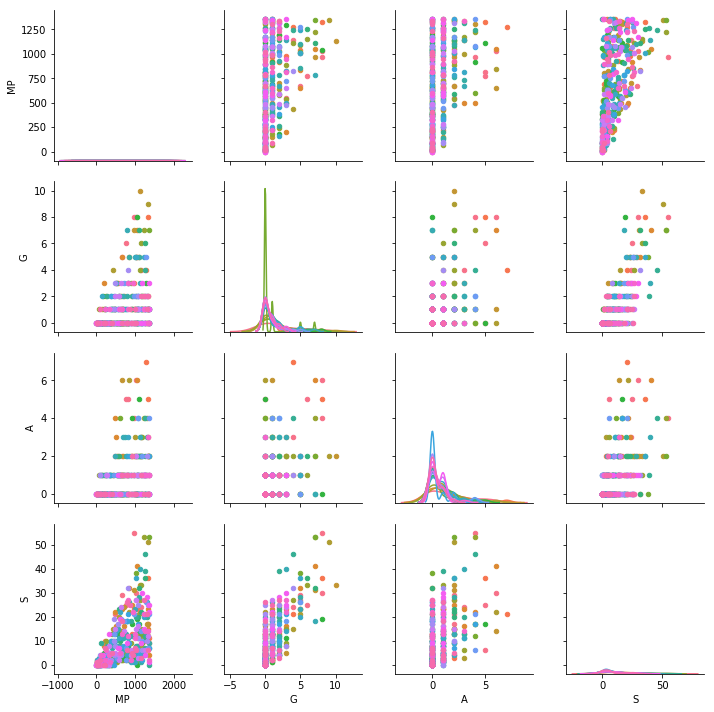

In [7]:
#All Players in the BPL
grid = sns.PairGrid(stats, vars=['MP', 'G', 'A', 'S'], hue="Team")
grid.map_diag(sns.kdeplot)
grid.map_offdiag(plt.scatter, s=20)

C:\Users\caruanacr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\caruanacr\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\caruanacr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\caruanacr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


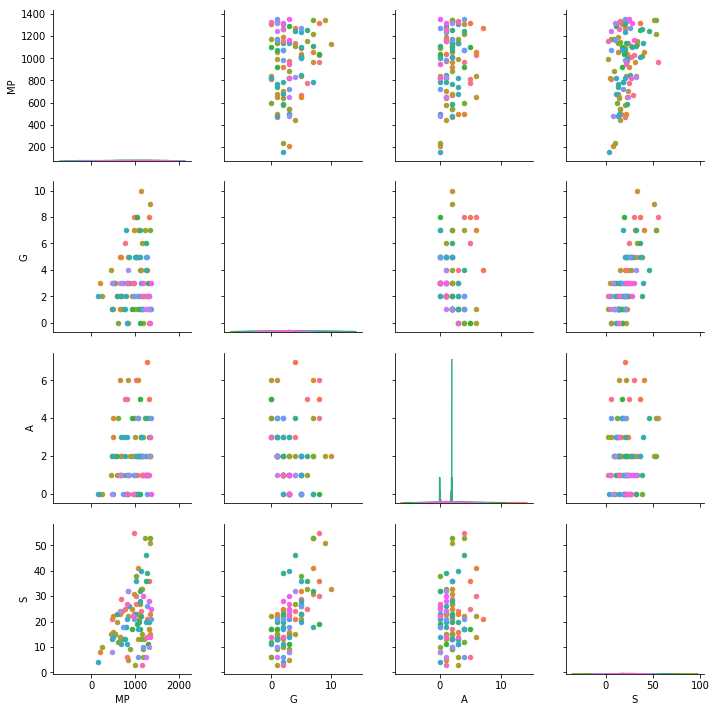

In [8]:
#Only Top 100 BPL Players
grid = sns.PairGrid(top100, vars=['MP', 'G', 'A', 'S'], hue="Team")
grid.map_diag(sns.kdeplot)
grid.map_offdiag(plt.scatter, s=20)

The above grids show that the top100 players are representative of the entire league

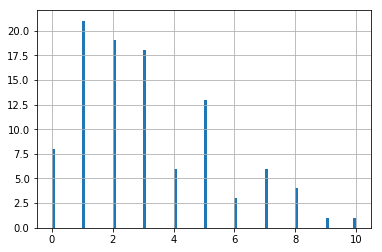

In [9]:
#Goals Histogram
top100.G.hist(bins=100)

Goals per game vs Shots per Game


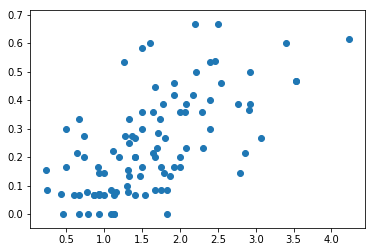

In [10]:
#Goals per Game
top100['GpGP'] = top100['G']/top100['GP']
#Shots per Game
top100['SpGP'] = top100['S']/top100['GP']

top100['GpGP'] = top100['GpGP'].astype('double')
top100['SpGP'] = top100['SpGP'].astype('double')

plt.scatter(top100.SpGP, top100.GpGP)
print("Goals per game vs Shots per Game")

## Data Modeling and Prediction

#### Using Training and Validation Sets

In [11]:
# Import Linear Regression
import sklearn
from sklearn.linear_model import LinearRegression

In [12]:
# create X and y
feature_cols = ['S', 'SOT', 'GP', 'FS']
X = top100[feature_cols]
y = top100['G']

# follow the usual sklearn pattern: import, instantiate, fit
lm = LinearRegression()
lm.fit(X, y)

# print intercept and coefficients
print (lm.intercept_)
print (lm.coef_)

1.090788403535797
[-0.00655234  0.341377   -0.09261246  0.03592646]


In [13]:
# pair the feature names with the coefficients
for i, j in zip(feature_cols, lm.coef_):
    print(i, j)

S -0.006552343921651039
SOT 0.34137699799061
GP -0.09261246451436417
FS 0.03592645700951478


### Prediction of Player with given stats 

In [14]:
# predict goals for player with 30 shots, 14 on target, 12 games, 17 fouls suffered
lm.predict([[30, 14, 12, 17]])

array([5.17289625])

In [15]:
# calculate the R-squared
lm.score(X, y)

0.6228724984349161

Linear Model Regression Plot of Shots vs Goals


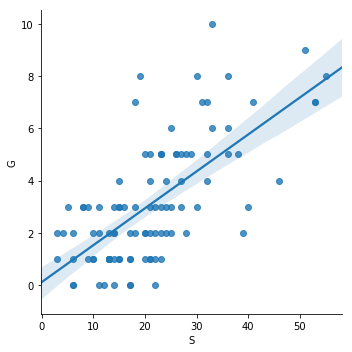

In [16]:
# Use seaborn to create and plot a linear fit
sns.lmplot('S','G',data = top100)
print ('Linear Model Regression Plot of Shots vs Goals')

In [17]:
# Create a LinearRegression Object
lreg = LinearRegression()
# Data Columns
X_multi = top100.drop(['GpGP', 'Player', 'Pos', 'Team', 'Rank'], 1)

# Targets
Y_target = top100.GpGP

# Implement Linear Regression
lreg.fit(X_multi,Y_target)
print(' The estimated intercept coefficient is %.2f ' %lreg.intercept_)
print(' The number of coefficients used was %d ' % len(lreg.coef_))

 The estimated intercept coefficient is 0.36 
 The number of coefficients used was 16 


In [18]:
import pandas as pd
from pandas import Series, DataFrame
# Create a DataFrame from the Features
coeff_df = DataFrame(X_multi.columns)
coeff_df.columns = ['Features']

# Add a new column with the coefficients from the linear regression
coeff_df["Coefficient Estimate"] = pd.Series(lreg.coef_)

# Show
print ('Table 1. Multivariate coefficients')
coeff_df

Table 1. Multivariate coefficients


,Features,Coefficient Estimate
0,GP,-0.028952
1,GS,-0.002302
2,G,0.050926
3,A,-0.025386
4,Pts,0.025541
5,SOT,-0.001543
6,S,-0.011479
7,Min/G,-0.004661
8,FC,0.000312
9,FS,-0.000004


With the Coefficient Estimate, it is shown that Shot per Games Played is the strongest correlation to goals per game.

In [19]:
X = top100.SpGP
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,top100.G, test_size=0.4, random_state=0)

# Print shapes of the training and testing data sets
print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

# numpy expects matrix with dimension column
X_train = X_train.values.reshape(X_train.shape[0],1)
Y_train = Y_train.values.reshape(Y_train.shape[0],1)
X_test = X_test.values.reshape(X_test.shape[0],1)
Y_test = Y_test.values.reshape(Y_test.shape[0],1)

print (X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(60,) (40,) (60,) (40,)
(60, 1) (40, 1) (60, 1) (40, 1)


In [20]:
# Regression object
lreg = LinearRegression()

# Build a linear regression model on the training data only
lreg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
# Predictions on training and testing sets
pred_train = lreg.predict(X_train)
pred_test = lreg.predict(X_test)

print ("Fit a model X_train, and calculate MSE with Y_train: %.2f"  % np.mean((Y_train - pred_train) ** 2) ) 
print ("Fit a model X_train, and calculate MSE with X_test and Y_test: %.2f"  % np.mean((Y_test - pred_test) ** 2) )

Fit a model X_train, and calculate MSE with Y_train: 3.08
Fit a model X_train, and calculate MSE with X_test and Y_test: 2.90


Text(0.5,1,'Residual Plots')

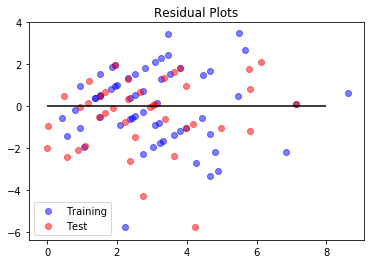

In [22]:
# Scatter plot the training data
train = plt.scatter(pred_train,(pred_train-Y_train),c='b',alpha=0.5)

# Scatter plot the testing data
test = plt.scatter(pred_test,(pred_test-Y_test),c='r',alpha=0.5)

# Plot a horizontal axis line at 0
plt.hlines(y=0,xmin=0,xmax=8)

#Labels
plt.legend((train,test),('Training','Test'),loc='lower left')
plt.title('Residual Plots')

Looks like there aren't any major patterns to be concerned about. Overall the majority of the residuals seem to be randomly distributed above and below the horizontal.

### Predicting Goals from shots per game

In [23]:
# Predicting Goals for a player with 3 shots per game
lreg.predict(3)

array([[5.96940669]])

In [24]:
#Expected Goals
top100['EG'] = top100.apply(lambda row: lreg.predict(row.SpGP), axis=1)
top100['EG'] = top100['EG'].astype('double')
top100.head()

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,...,FC,FS,YC,RC,DPt,SP,MP,GpGP,SpGP,EG
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,...,16,21,1,0,19,0.533333,1026.0,0.666667,2.500000,4.891537
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,...,24,19,3,0,33,0.444444,1321.5,0.533333,2.400000,4.675962
2,"Hazard, Eden",CHE,T2,F,14,11,7,6,13,17,...,4,43,2,0,10,0.414634,1052.8,0.500000,2.928571,5.815425
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,...,4,13,0,0,4,0.454545,1126.5,0.666667,2.200000,4.244814
4,"Agüero, Sergio",MCI,T4,F,13,13,8,4,12,19,...,8,8,2,0,14,0.345455,964.6,0.615385,4.230769,8.622626


EG, or expected goals, is now set for each individual top 100 player. The value represents how many goals the player should have based on how many shots per game they take. Some players are above their EG (which is good for the player), some are below their EG.

### Adding Future Fixture Difficulties into Players
Different teams have a different difficulty to play against.  This means that players won't play the same and can not be expected to do the same against an easy team compared to a more difficult team.  This fixture takes into the account the difficulty of each players next 5 games.

In [25]:
#Average fixture difficulty for the next 5 GameWeeks
#stats['Fix_5'] = 0
#Fixture Difficulty for GameWeeks
stats['Fix_GW11'] = 0
stats['Fix_GW12'] = 0
stats['Fix_GW13'] = 0
stats['Fix_GW14'] = 0
stats['Fix_GW15'] = 0
stats['Fix_GW16'] = 0
stats['Fix_GW17'] = 0
stats['Fix_GW18'] = 0


#Arsenal
stats.loc[stats['Team'] == "ARS", 'Fix_GW11'] = 4
stats.loc[stats['Team'] == "ARS", 'Fix_GW12'] = 3
stats.loc[stats['Team'] == "ARS", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "ARS", 'Fix_GW14'] = 4
stats.loc[stats['Team'] == "ARS", 'Fix_GW15'] = 4
stats.loc[stats['Team'] == "ARS", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "ARS", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "ARS", 'Fix_GW18'] = 2

#Bournemouth
stats.loc[stats['Team'] == "BOUR", 'Fix_GW11'] = 4
stats.loc[stats['Team'] == "BOUR", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "BOUR", 'Fix_GW13'] = 4
stats.loc[stats['Team'] == "BOUR", 'Fix_GW14'] = 5
stats.loc[stats['Team'] == "BOUR", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "BOUR", 'Fix_GW16'] = 4
stats.loc[stats['Team'] == "BOUR", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "BOUR", 'Fix_GW18'] = 2


#Brighton
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW17'] = 4
stats.loc[stats['Team'] == "BRIGHT", 'Fix_GW18'] = 3

#Burnley
stats.loc[stats['Team'] == "BURN", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "BURN", 'Fix_GW12'] = 3
stats.loc[stats['Team'] == "BURN", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "BURN", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "BURN", 'Fix_GW15'] = 4
stats.loc[stats['Team'] == "BURN", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "BURN", 'Fix_GW17'] = 4
stats.loc[stats['Team'] == "BURN", 'Fix_GW18'] = 4

#Cardiff
stats.loc[stats['Team'] == "CAR", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "CAR", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "CAR", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "CAR", 'Fix_GW14'] = 3
stats.loc[stats['Team'] == "CAR", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "CAR", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "CAR", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "CAR", 'Fix_GW18'] = 4

#Chelsea
stats.loc[stats['Team'] == "CHE", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "CHE", 'Fix_GW12'] = 3
stats.loc[stats['Team'] == "CHE", 'Fix_GW13'] = 4
stats.loc[stats['Team'] == "CHE", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "CHE", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "CHE", 'Fix_GW16'] = 5
stats.loc[stats['Team'] == "CHE", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "CHE", 'Fix_GW18'] = 3

#Crystal Palace
stats.loc[stats['Team'] == "CRY", 'Fix_GW11'] = 4
stats.loc[stats['Team'] == "CRY", 'Fix_GW12'] = 4
stats.loc[stats['Team'] == "CRY", 'Fix_GW13'] = 4
stats.loc[stats['Team'] == "CRY", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "CRY", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "CRY", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "CRY", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "CRY", 'Fix_GW18'] = 5

#Everton
stats.loc[stats['Team'] == "EVE", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "EVE", 'Fix_GW12'] = 4
stats.loc[stats['Team'] == "EVE", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "EVE", 'Fix_GW14'] = 5
stats.loc[stats['Team'] == "EVE", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "EVE", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "EVE", 'Fix_GW17'] = 5
stats.loc[stats['Team'] == "EVE", 'Fix_GW18'] = 4

#Fulham
stats.loc[stats['Team'] == "FUL", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "FUL", 'Fix_GW12'] = 5
stats.loc[stats['Team'] == "FUL", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "FUL", 'Fix_GW14'] = 4
stats.loc[stats['Team'] == "FUL", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "FUL", 'Fix_GW16'] = 4
stats.loc[stats['Team'] == "FUL", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "FUL", 'Fix_GW18'] = 2

#Huddersfield
stats.loc[stats['Team'] == "HUD", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "HUD", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "HUD", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "HUD", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "HUD", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "HUD", 'Fix_GW16'] = 4
stats.loc[stats['Team'] == "HUD", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "HUD", 'Fix_GW18'] = 2

#Leicester
stats.loc[stats['Team'] == "LEIC", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "LEIC", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "LEIC", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "LEIC", 'Fix_GW14'] = 3
stats.loc[stats['Team'] == "LEIC", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "LEIC", 'Fix_GW16'] = 4
stats.loc[stats['Team'] == "LEIC", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "LEIC", 'Fix_GW18'] = 4

#Liverpool
stats.loc[stats['Team'] == "LIV", 'Fix_GW11'] = 4
stats.loc[stats['Team'] == "LIV", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "LIV", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "LIV", 'Fix_GW14'] = 3
stats.loc[stats['Team'] == "LIV", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "LIV", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "LIV", 'Fix_GW17'] = 4
stats.loc[stats['Team'] == "LIV", 'Fix_GW18'] = 3

#Manchester City
stats.loc[stats['Team'] == "MCI", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "MCI", 'Fix_GW12'] = 4
stats.loc[stats['Team'] == "MCI", 'Fix_GW13'] = 3
stats.loc[stats['Team'] == "MCI", 'Fix_GW14'] = 3
stats.loc[stats['Team'] == "MCI", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "MCI", 'Fix_GW16'] = 4
stats.loc[stats['Team'] == "MCI", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "MCI", 'Fix_GW18'] = 2

#Manchester United
stats.loc[stats['Team'] == "MUN", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "MUN", 'Fix_GW12'] = 5
stats.loc[stats['Team'] == "MUN", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "MUN", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "MUN", 'Fix_GW15'] = 4
stats.loc[stats['Team'] == "MUN", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "MUN", 'Fix_GW17'] = 5
stats.loc[stats['Team'] == "MUN", 'Fix_GW18'] = 2

#Newcastle
stats.loc[stats['Team'] == "NEW", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "NEW", 'Fix_GW12'] = 3
stats.loc[stats['Team'] == "NEW", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "NEW", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "NEW", 'Fix_GW15'] = 3
stats.loc[stats['Team'] == "NEW", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "NEW", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "NEW", 'Fix_GW18'] = 2

#Southampton
stats.loc[stats['Team'] == "SOU", 'Fix_GW11'] = 5
stats.loc[stats['Team'] == "SOU", 'Fix_GW12'] = 3
stats.loc[stats['Team'] == "SOU", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "SOU", 'Fix_GW14'] = 4
stats.loc[stats['Team'] == "SOU", 'Fix_GW15'] = 4
stats.loc[stats['Team'] == "SOU", 'Fix_GW16'] = 2
stats.loc[stats['Team'] == "SOU", 'Fix_GW17'] = 4
stats.loc[stats['Team'] == "SOU", 'Fix_GW18'] = 2

#Spurs
stats.loc[stats['Team'] == "TOT", 'Fix_GW11'] = 3
stats.loc[stats['Team'] == "TOT", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "TOT", 'Fix_GW13'] = 4
stats.loc[stats['Team'] == "TOT", 'Fix_GW14'] = 4
stats.loc[stats['Team'] == "TOT", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "TOT", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "TOT", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "TOT", 'Fix_GW18'] = 3

#Watford
stats.loc[stats['Team'] == "WAT", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "WAT", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "WAT", 'Fix_GW13'] = 4
stats.loc[stats['Team'] == "WAT", 'Fix_GW14'] = 3
stats.loc[stats['Team'] == "WAT", 'Fix_GW15'] = 5
stats.loc[stats['Team'] == "WAT", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "WAT", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "WAT", 'Fix_GW18'] = 3

#West Ham
stats.loc[stats['Team'] == "WHU", 'Fix_GW11'] = 2
stats.loc[stats['Team'] == "WHU", 'Fix_GW12'] = 2
stats.loc[stats['Team'] == "WHU", 'Fix_GW13'] = 5
stats.loc[stats['Team'] == "WHU", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "WHU", 'Fix_GW15'] = 2
stats.loc[stats['Team'] == "WHU", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "WHU", 'Fix_GW17'] = 3
stats.loc[stats['Team'] == "WHU", 'Fix_GW18'] = 2

#Wolves
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW11'] = 4
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW12'] = 4
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW13'] = 2
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW14'] = 2
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW15'] = 4
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW16'] = 3
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW17'] = 2
stats.loc[stats['Team'] == "WOLVES", 'Fix_GW18'] = 4

In [26]:
#Average fixture difficulty for the next 5 GameWeeks
#top100['Fix_5'] = stats['Fix_5'].copy()
#Fixture Difficulty for GameWeeks
top100['Fix_GW11'] = stats['Fix_GW11'].copy()
top100['Fix_GW12'] = stats['Fix_GW12'].copy()
top100['Fix_GW13'] = stats['Fix_GW13'].copy()
top100['Fix_GW14'] = stats['Fix_GW14'].copy()
top100['Fix_GW15'] = stats['Fix_GW15'].copy()
top100['Fix_GW16'] = stats['Fix_GW16'].copy()
top100['Fix_GW17'] = stats['Fix_GW17'].copy()
top100['Fix_GW18'] = stats['Fix_GW18'].copy()

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(top100)

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,S,Min/G,FC,FS,YC,RC,DPt,SP,MP,GpGP,SpGP,EG,Fix_GW11,Fix_GW12,Fix_GW13,Fix_GW14,Fix_GW15,Fix_GW16,Fix_GW17,Fix_GW18
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,30,85.5,16,21,1,0,19,0.533333,1026.0,0.666667,2.500000,4.891537,2,4,3,3,3,4,3,2
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,36,88.1,24,19,3,0,33,0.444444,1321.5,0.533333,2.400000,4.675962,4,2,4,5,2,4,3,2
2,"Hazard, Eden",CHE,T2,F,14,11,7,6,13,17,41,75.2,4,43,2,0,10,0.414634,1052.8,0.500000,2.928571,5.815425,2,3,4,2,3,5,3,3
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,33,75.1,4,13,0,0,4,0.454545,1126.5,0.666667,2.200000,4.244814,4,3,3,4,4,2,2,2
4,"Agüero, Sergio",MCI,T4,F,13,13,8,4,12,19,55,74.2,8,8,2,0,14,0.345455,964.6,0.615385,4.230769,8.622626,2,4,3,3,3,4,3,2
5,"Kane, Harry",TOT,T6,F,15,15,9,2,11,27,51,89.6,18,34,3,0,27,0.529412,1344.0,0.600000,3.400000,6.831703,3,2,4,4,2,3,2,3
6,"Fraser, Ryan",BOUR,T6,M,15,15,4,7,11,10,21,85.0,0,26,1,0,3,0.476190,1275.0,0.266667,1.400000,2.520222,4,2,4,5,2,4,3,2
7,Mohamed Salah,LIV,T6,F,15,14,7,4,11,24,53,81.3,12,14,0,0,12,0.452830,1219.5,0.466667,3.533333,7.119135,4,2,3,3,2,3,4,3
8,"Sané, Leroy",MCI,T6,F,13,8,6,5,11,12,25,59.5,3,6,1,0,6,0.480000,773.5,0.461538,1.923077,3.647840,2,4,3,3,3,4,3,2
9,"Mitrovic, Aleksandar",FUL,T10,F,15,15,7,2,9,19,53,89.7,21,24,4,0,33,0.358491,1345.5,0.466667,3.533333,7.119135,2,5,2,4,3,4,2,2


In [27]:
# Gaccuracy is a players accuracy for the goal. It's their total goals minus expected goals to see if they
# are overperforming or underperforming based on shots made.
top100['Gaccuracy'] = top100['G']-top100['EG']
# To determine player worth in the next 3 weeks, the average difficulty of their next 3 fixtures divided by ten was
# normalized at 1 and multiplied by their accuracy for goal prediction made earlier.
top100['PlayerWorth'] = top100['Gaccuracy'] * ((1.3-(top100.Fix_GW16)/10)*300) * ((top100['MP']/100))
                                                                                   
worth= pd.DataFrame 
worth = top100.copy()
worth = worth.sort_values(['PlayerWorth'], ascending=False)
worth.head(40)

,Player,Team,Rank,Pos,GP,GS,G,A,Pts,SOT,...,Fix_GW11,Fix_GW12,Fix_GW13,Fix_GW14,Fix_GW15,Fix_GW16,Fix_GW17,Fix_GW18,Gaccuracy,PlayerWorth
3,"Aubameyang, Pierre-Emerick",ARS,T4,F,15,13,10,2,12,15,...,4,3,3,4,4,2,2,2,5.755186,21394.614649
11,"Murray, Glenn",BRIGHT,T12,F,15,13,8,0,8,10,...,3,2,3,2,2,2,4,3,5.767210,19783.548496
1,"Wilson, Callum",BOUR,T2,F,15,15,8,5,13,16,...,4,2,4,5,2,4,3,2,3.324038,11860.332057
16,"Martial, Anthony",MUN,T15,F,12,9,7,0,7,12,...,3,5,2,2,4,2,5,2,4.264204,11077.378127
26,Felipe Anderson,WHU,T24,M,15,15,5,1,6,11,...,2,2,5,2,2,3,3,2,2.623494,9763.332480
5,"Kane, Harry",TOT,T6,F,15,15,9,2,11,27,...,3,2,4,4,2,3,2,3,2.168297,8742.574197
10,"Lacazette, Alexandre",ARS,T10,F,14,9,7,2,9,13,...,4,3,3,4,4,2,2,2,2.724389,8684.808189
0,"Sterling, Raheem",MCI,1,F,12,12,8,6,14,16,...,2,4,3,3,3,4,3,2,3.108463,8611.065535
51,"Duffy, Shane",BRIGHT,T51,D,15,15,3,1,4,6,...,3,2,3,2,2,2,4,3,1.916938,8150.916595
34,Lucas Moura,TOT,T34,M,14,13,5,0,5,8,...,3,2,4,4,2,3,2,3,2.264204,7417.531729
